In [1]:
import numpy as np
import pandas as pd
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import keras
from keras import optimizers
import tensorflow as tf

from keras.utils import np_utils
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer

from keras.models import Model, Sequential
from keras.layers import Input, Dense, Embedding, GlobalAveragePooling1D, Activation, Flatten, Dropout, MaxPooling1D, Embedding, GlobalMaxPooling1D

from keras.layers.core import Dense, Dropout

import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("ticks")

from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

import pickle

C:\Users\LASYA\Anaconda3\lib\site-packages\h5py\__init__.py:72: UserWarning: h5py is running against HDF5 1.10.2 when it was built against 1.10.3, this may cause problems
  '{0}.{1}.{2}'.format(*version.hdf5_built_version_tuple)
Using TensorFlow backend.


In [2]:
# Read the CSV file
train = pd.read_csv('train.csv')
print(len(train))
test = pd.read_csv('test.csv')
print(len(test))
df_full = pd.concat([train,test])
print(len(df_full))

82657
20665
103322


In [3]:
df_full.head()

,user_name,country,review_title,review_description,designation,points,price,province,region_1,region_2,winery,variety
0,NaN,Australia,Andrew Peace 2007 Peace Family Vineyard Chardo...,"Classic Chardonnay aromas of apple, pear and h...",Peace Family Vineyard,83,10.0,Australia Other,South Eastern Australia,NaN,Andrew Peace,Chardonnay
1,@wawinereport,US,North by Northwest 2014 Red (Columbia Valley (...,This wine is near equal parts Syrah and Merlot...,NaN,89,15.0,Washington,Columbia Valley (WA),Columbia Valley,North by Northwest,Red Blend
2,NaN,Italy,Renato Ratti 2007 Conca (Barolo),Barolo Conca opens with inky dark concentratio...,Conca,94,80.0,Piedmont,Barolo,NaN,Renato Ratti,Nebbiolo
3,@vossroger,France,Domaine l'Ancienne Cure 2010 L'Abbaye White (B...,It's impressive what a small addition of Sauvi...,L'Abbaye,87,22.0,Southwest France,Bergerac Sec,NaN,Domaine l'Ancienne Cure,Bordeaux-style White Blend
4,@vossroger,France,Château du Cèdre 2012 Le Cèdre Vintage Malbec ...,"This ripe, sweet wine is rich and full of drie...",Le Cèdre Vintage,88,33.0,France Other,Vin de Liqueur,NaN,Château du Cèdre,Malbec


In [4]:
variety_counts = pd.DataFrame(train['variety'].value_counts())
varieties = list(variety_counts.index[variety_counts['variety'] > 1000])
# total number of distinct varieties
len(varieties)

23

In [5]:
df = train[train['variety'].isin(varieties)]

In [6]:
# Count of each variety
df.variety.value_counts()

Pinot Noir                  10587
Chardonnay                   9403
Cabernet Sauvignon           7552
Red Blend                    7166
Bordeaux-style Red Blend     5497
Riesling                     4148
Sauvignon Blanc              4011
Syrah                        3316
Rosé                         2831
Merlot                       2471
Nebbiolo                     2242
Zinfandel                    2209
Sangiovese                   2165
Malbec                       2119
Portuguese Red               1969
White Blend                  1896
Sparkling Blend              1739
Tempranillo                  1448
Rhône-style Red Blend        1182
Pinot Gris                   1148
Champagne Blend              1133
Cabernet Franc               1095
Grüner Veltliner             1055
Name: variety, dtype: int64

In [7]:
#  level Code for each variety is stored in variety_code
df['variety_code'] = pd.Categorical(df.variety).codes

C:\Users\LASYA\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [8]:
df[['variety','variety_code']]

,variety,variety_code
0,Chardonnay,4
1,Red Blend,12
2,Nebbiolo,8
4,Malbec,6
5,Cabernet Sauvignon,2
...,...,...
82651,Chardonnay,4
82652,Tempranillo,20
82653,Cabernet Sauvignon,2
82655,Bordeaux-style Red Blend,0


In [9]:
x = df.review_description.values
y = df.variety_code.values

In [10]:
# Set the maximum number of words for tokenizing review_description
maxwords = 25000
tokenizer = Tokenizer(num_words = maxwords)
# applying this limit to review_description
tokenizer.fit_on_texts(x)
#Converting text to sequence
x_sequences  = tokenizer.texts_to_sequences(x)
# finding the maximum length of sequences
maxlen = max(len(x) for x in x_sequences)
print(maxlen)
# pad each sequence with the maximum length
x_sequences = sequence.pad_sequences(x_sequences, maxlen)

136


In [11]:
# Splitting the Train and Test set
x_train, x_test, y_train, y_test = train_test_split(x_sequences, y, test_size=0.20, random_state=22)

In [12]:
# Building the model
model = Sequential()
model.add(Embedding(input_dim=maxwords,
                    output_dim=136))

# add a GlobalAveragePooling1D, which will average the embeddings
# of all words in the document
model.add(GlobalAveragePooling1D())
model.add(Dropout(0.5))

model.add(Dense(100, activation="softmax"))

In [13]:
opt = keras.optimizers.Adam(lr=0.01) # speed up optimization
model.compile(optimizer=opt, loss="sparse_categorical_crossentropy", metrics=["acc"])

In [14]:
fit = model.fit(x_train, y_train,
            batch_size=512,
            epochs=10,
            validation_data=(x_test, y_test))

C:\Users\LASYA\Anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 62705 samples, validate on 15677 samples
Epoch 1/10
62705/62705 [==============================] - 29s 470us/step - loss: 2.7559 - acc: 0.2295 - val_loss: 2.0673 - val_acc: 0.3880
Epoch 2/10
62705/62705 [==============================] - 28s 439us/step - loss: 1.7356 - acc: 0.4730 - val_loss: 1.4076 - val_acc: 0.5760
Epoch 3/10
62705/62705 [==============================] - 30s 477us/step - loss: 1.2788 - acc: 0.6118 - val_loss: 1.1411 - val_acc: 0.6456
Epoch 4/10
62705/62705 [==============================] - 27s 437us/step - loss: 1.0574 - acc: 0.6767 - val_loss: 1.0188 - val_acc: 0.6883
Epoch 5/10
62705/62705 [==============================] - 27s 433us/step - loss: 0.9267 - acc: 0.7193 - val_loss: 0.9518 - val_acc: 0.7052
Epoch 6/10
62705/62705 [==============================] - 28s 441us/step - loss: 0.8350 - acc: 0.7473 - val_loss: 0.9138 - val_acc: 0.7202
Epoch 7/10
62705/62705 [==============================] - 28s 444us/step - loss: 0.7630 - acc: 0.7698 - val_loss: 0.

In [15]:
print('accuracy', model.evaluate(x_test, y_test)[1])

15677/15677 [==============================] - 3s 160us/step
accuracy 0.733558714389801


In [16]:
print('train accuracy', model.evaluate(x_train, y_train)[1])

62705/62705 [==============================] - 9s 143us/step
train accuracy 0.8521649241447449


In [20]:
y_pred1 = model.predict_classes(x_test)
# print(classification_report(y_test, y_pred4))

cm = confusion_matrix(y_test, y_pred1) # only works with sparse
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
accuracies = cm.diagonal()

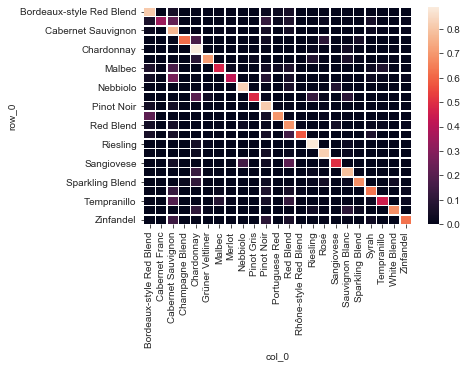

In [22]:
lookup = df[['variety_code', 'variety']].drop_duplicates().set_index('variety_code').to_dict()
lookup = lookup['variety']

y_test_name = np.array([lookup[y_code] for y_code in y_test])
y_pred_name = np.array([lookup[y_code] for y_code in y_pred1])

to_plot = pd.crosstab(y_test_name, y_pred_name, normalize='index')
sns.heatmap(to_plot,linewidths=.5)
plt.show()

In [23]:
labels = sorted(lookup.items(), key=lambda x: x[0])
labels = [vv[1] for vv in labels]

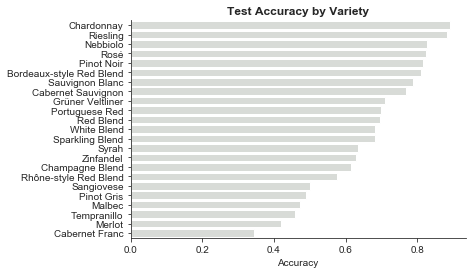

In [24]:
acc_order = np.argsort(-accuracies) # get index to sort by

sns.barplot(y=np.array(labels)[acc_order], x=accuracies[acc_order], color='#d8dcd6')
plt.title('Test Accuracy by Variety', fontweight="bold")
plt.xlabel('Accuracy')
sns.despine()
plt.show()

In [ ]:
# plot as histogram
plt.hist(accuracies, bins=6, color='navy')
plt.title('Test Accuracy by Variety', fontweight="bold")
plt.xlabel('Accuracy')
sns.despine()
plt.show()

In [ ]:
model.save('wine_model.h5')